In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

# 1. Load Processed Data (Saved in Step 2)
input_folder = '../data/processed'

# Load Features (X)
X_train = np.load(f'{input_folder}/X_train.npy')
X_val = np.load(f'{input_folder}/X_val.npy')
X_test = np.load(f'{input_folder}/X_test.npy')

# Load Targets (y)
y_train = np.load(f'{input_folder}/y_train.npy')
y_val = np.load(f'{input_folder}/y_val.npy')
y_test = np.load(f'{input_folder}/y_test.npy')

# Load Class Names (for reporting)
class_names = np.load(f'{input_folder}/class_names.npy', allow_pickle=True)

print(f"✅ Data Loaded Successfully!")
print(f"Training Data Shape: {X_train.shape}")
print(f"Number of Classes: {len(class_names)} {class_names}")


✅ Data Loaded Successfully!
Training Data Shape: (629136, 24)
Number of Classes: 7 ['A' 'B' 'C' 'D' 'E' 'F' 'G']


In [2]:
import os
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import class_weight

# --- KAYIT YERİ AYARLARI ---
model_folder = '../models'
os.makedirs(model_folder, exist_ok=True) 

# Model adını değiştirdik ki orijinali bozulmasın
model_path = f'{model_folder}/best_ann_model_weighted.h5'

print(f"💾 Model Path: {model_path}")

print("\n⚖️ Class weights are calculating...")

# 1. One-Hot (örn: [0,1,0]) formatındaki y_train'i normal sayılara (örn: 1) çevir
y_train_indices = np.argmax(y_train, axis=1)

# 2. Ağırlıkları Hesapla ('balanced' modu az olana yüksek puan verir)
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_indices),
    y=y_train_indices
)

#Keras için sözlük formatına çevir {0: 1.5, 1: 0.5 ...}
class_weights_dict = dict(enumerate(class_weights_vals))

#Ağırlıkları ekrana basalım ki görelim
for index, weight in class_weights_dict.items():
    print(f"   Sınıf {index}: {weight:.2f}x katsayı")


# --- MODEL MİMARİSİ (Aynı Kalıyor) ---
model = keras.Sequential([
    # Giriş Katmanı + 1. Gizli Katman
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    
    # Dropout 
    keras.layers.Dropout(0.3),
    
    # 2. Gizli Katman
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    
    # 3. Gizli Katman
    keras.layers.Dense(32, activation='relu'),
    
    # Çıkış Katmanı
    keras.layers.Dense(len(class_names), activation='softmax')
])

# Modeli Derle
model.compile(
    optimizer='adam',  
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

model.summary()

# --- CALLBACKS ---
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,                
    restore_best_weights=True, 
    verbose=1
)

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    save_best_only=True,      
    monitor='val_loss',       
    mode='min',               
    verbose=1
)

print("\n🚀 Weighted Training...")


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,          
    batch_size=32,       
    callbacks=[early_stopping, checkpoint_cb],
    class_weight=class_weights_dict, 
    verbose=1
)

💾 Model Path: ../models/best_ann_model_weighted.h5

⚖️ Class weights are calculating...
   Sınıf 0: 0.68x katsayı
   Sınıf 1: 0.55x katsayı
   Sınıf 2: 0.55x katsayı
   Sınıf 3: 1.13x katsayı
   Sınıf 4: 2.12x katsayı
   Sınıf 5: 4.50x katsayı
   Sınıf 6: 3.13x katsayı


C:\Users\mehme\anaconda3\envs\env_enery_rating\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,767 (53.78 KB)

 Trainable params: 13,767 (53.78 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Weighted Training...
Epoch 1/100
19659/19661 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6805 - loss: 0.8590
Epoch 1: val_loss improved from None to 0.49237, saving model to ../models/best_ann_model_weighted.h5


19661/19661 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.7273 - loss: 0.7396 - val_accuracy: 0.7843 - val_loss: 0.4924
Epoch 2/100
19653/19661 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7620 - loss: 0.6474
Epoch 2: val_loss did not improve from 0.49237
19661/19661 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 0.7642 - loss: 0.6380 - val_accuracy: 0.7763 - val_loss: 0.4976
Epoch 3/100
19660/19661 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7696 - loss: 0.6224
Epoch 3: val_loss did not improve from 0.49237
19661/19661 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.7712 - loss: 0.6201 - val_accuracy: 0.7751 - val_loss: 0.4952
Epoch 4/100
19657/19661 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7747 - loss: 0.6081
Epoch 4: val_loss did not improve from 0.49237
19661/19661 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.7751 - loss: 0.6088 - val_accuracy: 0.7740 - val_loss: 0.5002
Epoch 5/100
19650/19661 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7775 - loss: 0.6054
Epoch 5

19661/19661 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - accuracy: 0.7838 - loss: 0.5884 - val_accuracy: 0.7921 - val_loss: 0.4759
Epoch 8/100
19656/19661 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7865 - loss: 0.5833
Epoch 8: val_loss improved from 0.47593 to 0.47436, saving model to ../models/best_ann_model_weighted.h5


19661/19661 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.7866 - loss: 0.5817 - val_accuracy: 0.7935 - val_loss: 0.4744
Epoch 9/100
19654/19661 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7888 - loss: 0.5745
Epoch 9: val_loss did not improve from 0.47436
19661/19661 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.7889 - loss: 0.5744 - val_accuracy: 0.7777 - val_loss: 0.4958
Epoch 10/100
19661/19661 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7886 - loss: 0.5750
Epoch 10: val_loss did not improve from 0.47436
19661/19661 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.7895 - loss: 0.5729 - val_accuracy: 0.7898 - val_loss: 0.4812
Epoch 11/100
19657/19661 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7903 - loss: 0.5679
Epoch 11: val_loss did not improve from 0.47436
19661/19661 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.7909 - loss: 0.5683 - val_accuracy: 0.7868 - val_loss: 0.4820
Epoch 12/100
19651/19661 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7914 - loss: 0.5679
Ep

19661/19661 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - accuracy: 0.7951 - loss: 0.5560 - val_accuracy: 0.7926 - val_loss: 0.4740
Epoch 18/100
19653/19661 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7975 - loss: 0.5526
Epoch 18: val_loss did not improve from 0.47396
19661/19661 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/step - accuracy: 0.7969 - loss: 0.5533 - val_accuracy: 0.7798 - val_loss: 0.4942
Epoch 19/100
19659/19661 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7960 - loss: 0.5549
Epoch 19: val_loss improved from 0.47396 to 0.47197, saving model to ../models/best_ann_model_weighted.h5


19661/19661 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.7964 - loss: 0.5535 - val_accuracy: 0.7956 - val_loss: 0.4720
Epoch 20/100
19651/19661 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7986 - loss: 0.5500
Epoch 20: val_loss did not improve from 0.47197
19661/19661 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.7976 - loss: 0.5502 - val_accuracy: 0.7658 - val_loss: 0.5249
Epoch 21/100
19644/19661 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7975 - loss: 0.5512
Epoch 21: val_loss did not improve from 0.47197
19661/19661 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - accuracy: 0.7976 - loss: 0.5498 - val_accuracy: 0.7893 - val_loss: 0.4795
Epoch 22/100
19653/19661 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7981 - loss: 0.5494
Epoch 22: val_loss did not improve from 0.47197
19661/19661 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - accuracy: 0.7978 - loss: 0.5498 - val_accuracy: 0.7838 - val_loss: 0.4877
Epoch 23/100
19658/19661 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7984 - loss: 0.5485


19661/19661 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 0.7978 - loss: 0.5469 - val_accuracy: 0.8033 - val_loss: 0.4510
Epoch 25/100
19650/19661 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7983 - loss: 0.5466
Epoch 25: val_loss did not improve from 0.45102
19661/19661 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.7987 - loss: 0.5478 - val_accuracy: 0.7958 - val_loss: 0.4618
Epoch 26/100
19649/19661 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7995 - loss: 0.5483
Epoch 26: val_loss did not improve from 0.45102
19661/19661 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.7988 - loss: 0.5465 - val_accuracy: 0.7954 - val_loss: 0.4660
Epoch 27/100
19644/19661 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7988 - loss: 0.5478
Epoch 27: val_loss did not improve from 0.45102
19661/19661 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - accuracy: 0.7991 - loss: 0.5460 - val_accuracy: 0.7870 - val_loss: 0.4826
Epoch 28/100
19659/19661 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8000 - loss: 0.5428


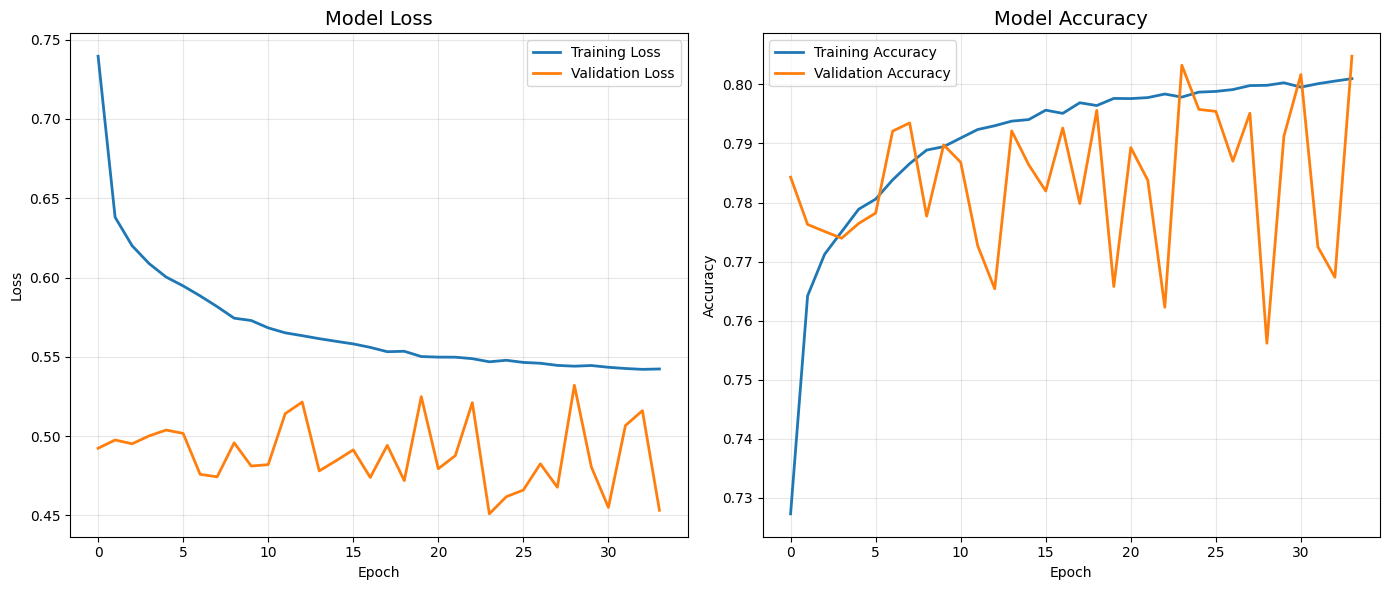

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

#history nesnesinden verileri al
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(14, 6))

#Loss
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Training Loss', linewidth=2)
plt.plot(history_df['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

#Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_df['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history_df['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Tahminler yapılıyor...
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step

🏆 Accuracy: %80.51
✨ Cohen's Kappa Score: 0.7570
--- Classification report ---
              precision    recall  f1-score   support

           A       1.00      0.82      0.90     43777
           B       0.82      0.87      0.84     54258
           C       0.84      0.80      0.82     54852
           D       0.67      0.72      0.70     26453
           E       0.60      0.72      0.66     14131
           F       0.50      0.72      0.59      6655
           G       0.88      0.82      0.85      9587

    accuracy                           0.81    209713
   macro avg       0.76      0.78      0.76    209713
weighted avg       0.82      0.81      0.81    209713



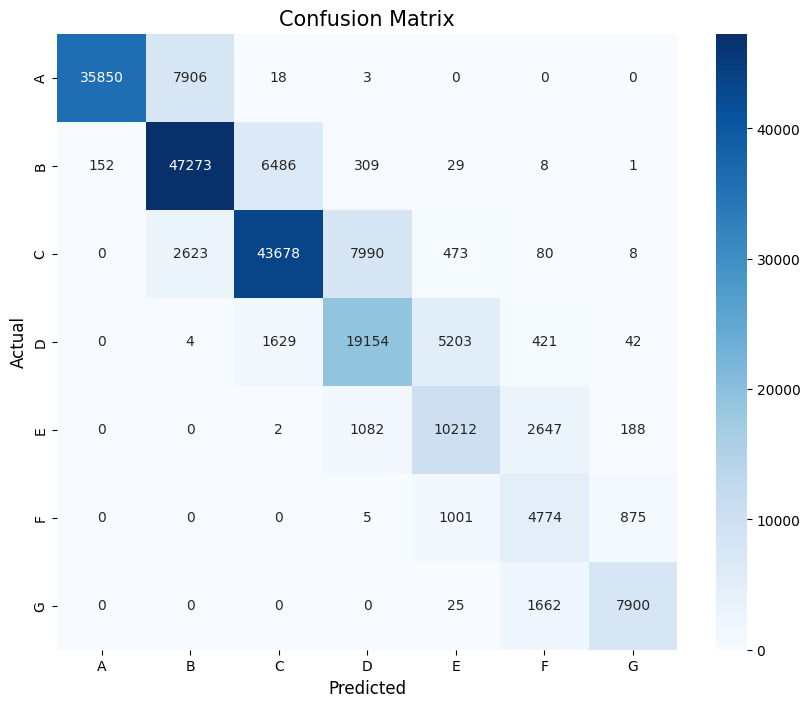

In [4]:
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, accuracy_score
import seaborn as sns

#Tahminleri Al
print("Tahminler yapılıyor...")
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# One-Hot formatındaki gerçek etiketleri (y_test) normale çevir
y_test_labels = np.argmax(y_test, axis=1)

#Genel Doğruluk (Accuracy)
test_acc = accuracy_score(y_test_labels, y_pred)
print(f"\n🏆 Accuracy: %{test_acc*100:.2f}")

#Cohen's Kappa Skoru (Ödevde İsteniyor)
kappa = cohen_kappa_score(y_test_labels, y_pred)
print(f"✨ Cohen's Kappa Score: {kappa:.4f}")

#Detaylı Sınıflandırma Raporu (Precision, Recall, F1)
print("--- Classification report ---")
print(classification_report(y_test_labels, y_pred, target_names=class_names))

#Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_labels, y_pred)


sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)

plt.title('Confusion Matrix', fontsize=15)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

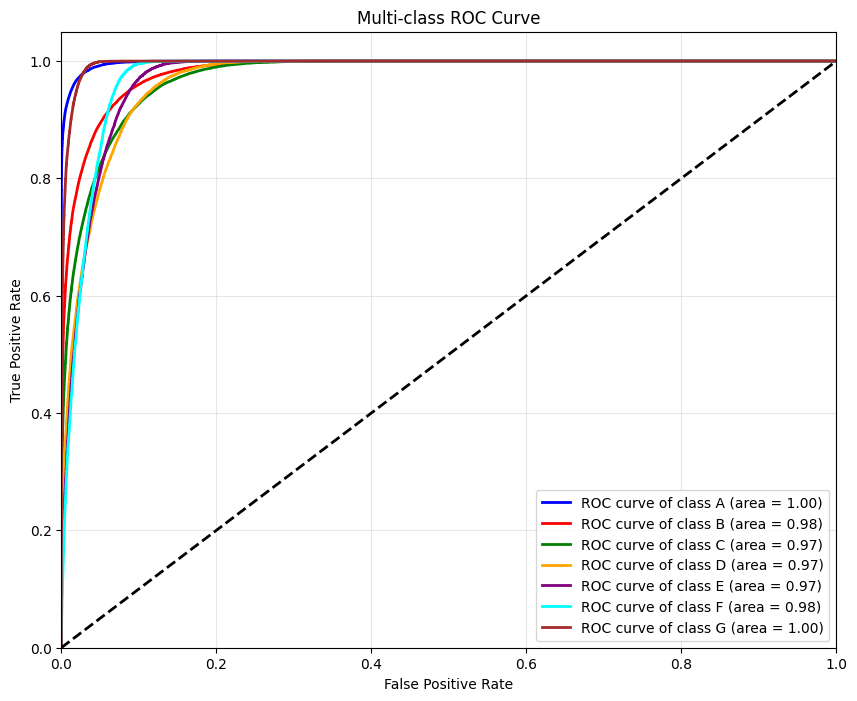

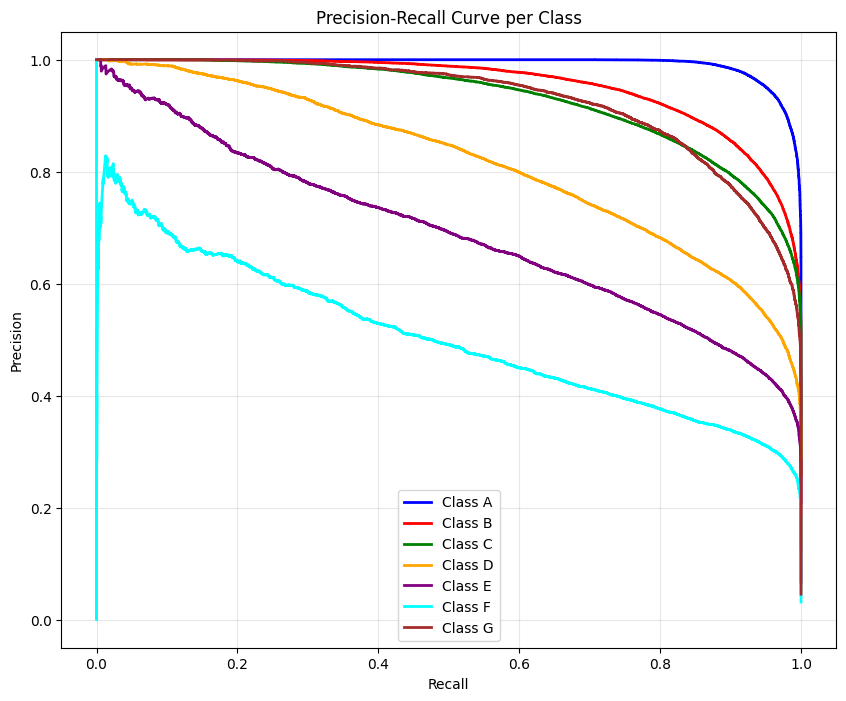

In [7]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from itertools import cycle

# 1. Verileri Hazırla
# y_test zaten One-Hot formatında (örn: [[1,0,0...], [0,1,0...]])
# y_pred_probs: Modelin olasılık tahminleri
n_classes = len(class_names)

# --- GRAFİK 1: ROC CURVE (Alıcı İşletim Karakteristiği) ---
plt.figure(figsize=(10, 8))

# Her sınıf için ROC eğrisini hesapla ve çiz
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'brown'])

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'ROC curve of class {class_names[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Rastgele tahmin çizgisi
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# --- GRAFİK 2: PRECISION-RECALL CURVE ---
plt.figure(figsize=(10, 8))

for i, color in zip(range(n_classes), colors):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred_probs[:, i])
    
    plt.plot(recall, precision, color=color, lw=2,
             label=f'Class {class_names[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve per Class')
plt.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.show()